In [ ]:
from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
from geopy.point import Point
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score
#from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


Using device: cuda



In [ ]:
drive.mount( '/content/drive', force_remount=True )

Mounted at /content/drive


In [ ]:
PATH = "/content/drive/MyDrive/for thesis" #change to the path to your folder with datasets and images
os.chdir(PATH)

In [ ]:
# Load the coordinates of all the images of the City Street View Dataset
#dataset available here: https://www.kaggle.com/datasets/stelath/city-street-view-dataset
gsv = pd.read_csv('picture_coords.csv',header=None)
print(gsv.head())

           0           1
0  40.864413  -73.893292
1  38.884714  -76.927431
2  42.367025  -83.115961
3  37.798462 -122.423526
4  41.699542  -87.690806


## Exploring police data

A popular dataset about San Francisco that contains information about its residents is the San Francisco Police Department (SFPD) Incident Report dataset. It includes information such as the time, location, and category of incidents that have been reported to the SFPD. The location data is given in the form of longitude and latitude, which can be mapped to the specific block, district, or street. The dataset is available for download on the San Francisco OpenData website: https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783 

Let's load it and see what's in there.

In [ ]:
# Read the .csv file
police = pd.read_csv('Police_Department_Incident_Reports__2018_to_Present.csv')
print(police.columns)
pd.set_option('display.max_columns', None)
display(police)

Index(['Incident Datetime', 'Incident Date', 'Incident Time', 'Incident Year',
       'Incident Day of Week', 'Report Datetime', 'Row ID', 'Incident ID',
       'Incident Number', 'CAD Number', 'Report Type Code',
       'Report Type Description', 'Filed Online', 'Incident Code',
       'Incident Category', 'Incident Subcategory', 'Incident Description',
       'Resolution', 'Intersection', 'CNN', 'Police District',
       'Analysis Neighborhood', 'Supervisor District', 'Latitude', 'Longitude',
       'Point', 'Neighborhoods', 'ESNCAG - Boundary File',
       'Central Market/Tenderloin Boundary Polygon - Updated',
       'Civic Center Harm Reduction Project Boundary',
       'HSOC Zones as of 2018-06-05', 'Invest In Neighborhoods (IIN) Areas',
       'Current Supervisor Districts', 'Current Police Districts'],
      dtype='object')


,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,Report Type Code,Report Type Description,Filed Online,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,Intersection,CNN,Police District,Analysis Neighborhood,Supervisor District,Latitude,Longitude,Point,Neighborhoods,ESNCAG - Boundary File,Central Market/Tenderloin Boundary Polygon - Updated,Civic Center Harm Reduction Project Boundary,HSOC Zones as of 2018-06-05,Invest In Neighborhoods (IIN) Areas,Current Supervisor Districts,Current Police Districts
0,2021/07/25 12:00:00 AM,2021/07/25,00:00,2021,Sunday,2021/07/25 01:41:00 PM,105718906372,1057189,216105573,NaN,II,Coplogic Initial,True,6372,Larceny Theft,Larceny Theft - Other,"Theft, Other Property, $50-$200",Open or Active,NaN,NaN,Southern,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022/06/28 11:58:00 PM,2022/06/28,23:58,2022,Tuesday,2022/06/28 11:58:00 PM,116554371012,1165543,220264913,NaN,VS,Vehicle Supplement,NaN,71012,Other Offenses,Other Offenses,"License Plate, Recovered",Open or Active,NaN,NaN,Out of SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022/03/11 10:30:00 AM,2022/03/11,10:30,2022,Friday,2022/03/11 08:03:00 PM,113048071000,1130480,226040232,NaN,II,Coplogic Initial,True,71000,Lost Property,Lost Property,Lost Property,Open or Active,NaN,NaN,Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021/05/15 05:47:00 PM,2021/05/15,17:47,2021,Saturday,2021/05/15 05:47:00 PM,103051807043,1030518,210183345,NaN,VS,Vehicle Supplement,NaN,7043,Recovered Vehicle,Recovered Vehicle,"Vehicle, Recovered, Motorcycle",Open or Active,NaN,NaN,Out of SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022/06/28 05:22:00 PM,2022/06/28,17:22,2022,Tuesday,2022/06/28 05:22:00 PM,116535107041,1165351,220361741,NaN,VS,Vehicle Supplement,NaN,7041,Recovered Vehicle,Recovered Vehicle,"Vehicle, Recovered, Auto",Open or Active,NaN,NaN,Out of SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693196,2023/02/09 04:48:00 PM,2023/02/09,16:48,2023,Thursday,2023/02/09 04:48:00 PM,124292363010,1242923,230097538,230402481.0,II,Initial,NaN,63010,Warrant,Other,"Warrant Arrest, Local SF Warrant",Cite or Arrest Adult,22ND ST \ CAPP ST,24082000.0,Mission,Mission,9.0,37.755502,-122.417659,POINT (-122.417658993747 37.75550249751555),53.0,NaN,NaN,NaN,3.0,NaN,2.0,3.0
693197,2023/02/01 08:00:00 AM,2023/02/01,08:00,2023,Wednesday,2023/02/09 04:20:00 PM,124289815410,1242898,230097334,230402375.0,II,Initial,NaN,15410,NaN,NaN,Cryptocurrency Related Crime (secondary code o...,Open or Active,34TH AVE \ ULLOA ST,23355000.0,Taraval,Sunset/Parkside,4.0,37.740475,-122.491635,POINT (-122.49163494114596 37.74047450560974),40.0,NaN,NaN,NaN,NaN,NaN,7.0,10.0
693198,2023/02/09 08:00:00 AM,2023/02/09,08:00,2023,Thursday,2023/02/09 12:15:00 PM,124285615201,1242856,230096825,230401513.0,II,Initial,NaN,15201,Offences Against The Family And Children,Stalking,Stalking,Open or Active,LAGUNA ST \ HAIGHT ST,25867000.0,Park,Hayes Valley,5.0,37.772734,-122.425512,POINT (-122.42551205721274 37.772734311063964),27.0,NaN,NaN,NaN,NaN,NaN,11.0,4.0
693199,2023/02/07 11:24:00 PM,2023/02/07,23:24,2023,Tuesday,2023/02/07 11:24:00 PM,124244375025,1242443,230093332,230383543.0,II,Initial,NaN,75025,Non-Criminal,Non-Criminal,Search Warrant Service,Open or Active,03RD ST \ LE CONTE AVE,20467000.0,Bayview,Bayview Hunters Point,10.0,37.718834,-122.397479,POINT (-122.39747873558031 37.718834357405456),88.0,NaN,NaN,NaN,NaN,NaN,9.0,2.0


In [ ]:
size = len(police)
print("The number of records in the dataset:",size)

The number of records in the dataset: 693201


In order to decide what data we could investigate with SVI, we have to see what types of records there are, how many types, how frequent the types are, how frequently do the records miss latitude and longitude coordinates. Of the records that have sufficient frequency, that don't miss too many lat-lon coordinates and of which the records with missing coordinates are not specific in any obvious way we pick the type of crime that might most likely be related to the street environment.

In [ ]:
print("How many unique incident descriptions:")
pd.unique(police['Incident Description']).size

How many unique incident descriptions:


838

In [ ]:
print("What are the incident subcategories:")
pd.unique(police['Incident Subcategory'])

What are the incident subcategories:


array(['Larceny Theft - Other', 'Other Offenses', 'Lost Property',
       'Recovered Vehicle', 'Vandalism', 'Larceny - From Vehicle',
       'Burglary - Hot Prowl', 'Missing Person', 'Fraud',
       'Traffic Violation Arrest', 'Trespass', 'Drug Violation',
       'Motor Vehicle Theft', 'Missing Adult', 'Burglary - Residential',
       'Other', 'Robbery - Commercial', 'Warrant', 'Theft From Vehicle',
       'Arson', 'Stolen Property', 'Aggravated Assault',
       'Weapons Offense', 'Drunkenness', 'Suspicious Occ', 'Non-Criminal',
       'Larceny Theft - Shoplifting', 'Courtesy Report', 'Case Closure',
       'Burglary - Commercial', 'Simple Assault',
       'Larceny Theft - From Building', 'Fire Report',
       'Miscellaneous Investigation', nan, 'Burglary - Other',
       'Disorderly Conduct', 'Larceny Theft - Bicycle',
       'Forgery And Counterfeiting', 'Intimidation', 'Robbery - Other',
       'Sex Offense', 'Motor Vehicle Theft (Attempted)',
       'Robbery - Street', 'Extortion-B

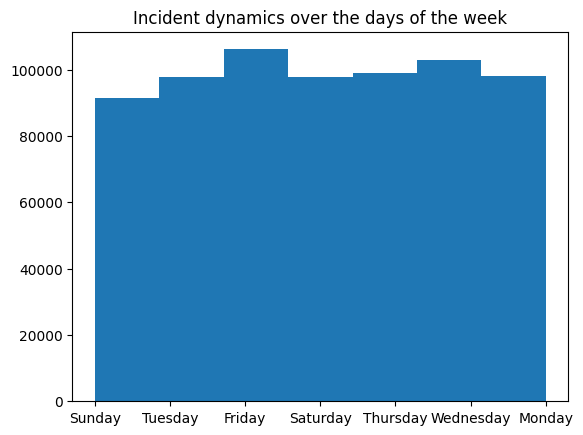

In [ ]:
plt.hist(police['Incident Day of Week'],bins=7)
plt.title("Incident dynamics over the days of the week")
plt.show()

Let's display the top incident descriptions with their counts and frequencies.

In [ ]:
print("The most oftenly occurring incident descriptions:")
descr = police.groupby(['Incident Description'])['Incident Description'].count().reset_index(name='count').sort_values(['count'],ascending=False)
descr['freq, %'] = round(descr['count']*100/size,2)
descr.head(10)

The most oftenly occurring incident descriptions:


,Incident Description,count,"freq, %"
706,"Theft, From Locked Vehicle, >$950",87810,12.67
417,"Malicious Mischief, Vandalism to Property",23070,3.33
84,Battery,20409,2.94
402,Lost Property,20240,2.92
727,"Theft, Other Property, $50-$200",19515,2.82
791,"Vehicle, Recovered, Auto",19506,2.81
802,"Vehicle, Stolen, Auto",18873,2.72
729,"Theft, Other Property, >$950",16478,2.38
429,Mental Health Detention,15374,2.22
716,"Theft, From Unlocked Vehicle, >$950",13068,1.89


Well, descriptions don't seem to be a good categorisation. What's "Battery" as a description of an incident, for example? Let's look at the higher granularity of descriptions - the categories of the incidents.

In [ ]:
print("The most frequent incidents:")
cat = police.groupby(['Incident Category'])['Incident Category'].count().reset_index(name='count').sort_values(['count'],ascending=False)
cat['freq, %'] = round(cat['count']*100/size,2)
cat.head(10)

The most frequent incidents:


,Incident Category,count,"freq, %"
18,Larceny Theft,211377,30.49
29,Other Miscellaneous,48443,6.99
21,Malicious Mischief,46937,6.77
1,Assault,42139,6.08
26,Non-Criminal,41405,5.97
2,Burglary,39063,5.64
24,Motor Vehicle Theft,35240,5.08
33,Recovered Vehicle,26870,3.88
12,Fraud,21929,3.16
20,Lost Property,20240,2.92


Okay, this is more concrete, though the second place is occupied by "other". What are the crimes that occur the least, by the way?

In [ ]:
print("The least frequent incidents:")
cat.tail(10)

The least frequent incidents:


,Incident Category,count,"freq, %"
32,Rape,166,0.02
15,"Human Trafficking (A), Commercial Sex Acts",129,0.02
14,Homicide,103,0.01
38,Suspicious,99,0.01
19,Liquor Laws,75,0.01
25,Motor Vehicle Theft?,74,0.01
13,Gambling,32,0.00
17,"Human Trafficking, Commercial Sex Acts",21,0.00
47,Weapons Offence,20,0.00
16,"Human Trafficking (B), Involuntary Servitude",1,0.00


If we already started looking at different levels of granularity, let's also look at the subcategories in order to not miss some interesting subcategory that would be interesting to investigate with the analysis of the environment.

In [ ]:
print("The most frequent subcategories:")
subcat = police.groupby(['Incident Subcategory'])['Incident Subcategory'].count().reset_index(name='count').sort_values(['count'],ascending=False)
subcat['freq, %'] = round(subcat['count']*100/size,2)
subcat.head(10)

The most frequent subcategories:


,Incident Subcategory,count,"freq, %"
27,Larceny - From Vehicle,120018,17.31
44,Other,86428,12.47
30,Larceny Theft - Other,48699,7.03
67,Vandalism,46611,6.72
41,Motor Vehicle Theft,34719,5.01
49,Recovered Vehicle,26870,3.88
56,Simple Assault,26177,3.78
43,Non-Criminal,23777,3.43
18,Fraud,22945,3.31
36,Lost Property,20240,2.92


In [ ]:
print("The least frequent subcategories:")
subcat.tail(10)

The least frequent subcategories:


,Incident Subcategory,count,"freq, %"
37,Manslaughter,57,0.01
48,Rape - Attempted,54,0.01
3,Bad Checks,46,0.01
20,Homicide,45,0.01
19,Gambling,32,0.00
53,Robbery - Residential,25,0.00
1,Arrest,6,0.00
4,Bribery,5,0.00
21,Homicide - Excusable,1,0.00
23,"Human Trafficking, Involuntary Servitude",1,0.00


Larceny from vehicle looks like concrete enough. At the same time it has enough data points. And it seems to be a crime that might be related to the street environment, as it only happens at the street.

#### How many latitudes and longitudes are missing

In [ ]:
print("ratio of records with missing latitude value:",police['Latitude'].isnull().sum()/size)
print("ratio of records with missing longitude value:",police['Longitude'].isnull().sum()/size)

ratio of records with missing latitude value: 0.053074072310917035
ratio of records with missing longitude value: 0.053074072310917035


Okay, seems like latitude and longitude are missing for the same records, because the ratio is so exactly the same. 

Are these records any specific though? We look into count of values of Incident Subcategory where Latitude (as well as Longitude, as we suspect) is missing.

It occurs with 58 categories out of 73


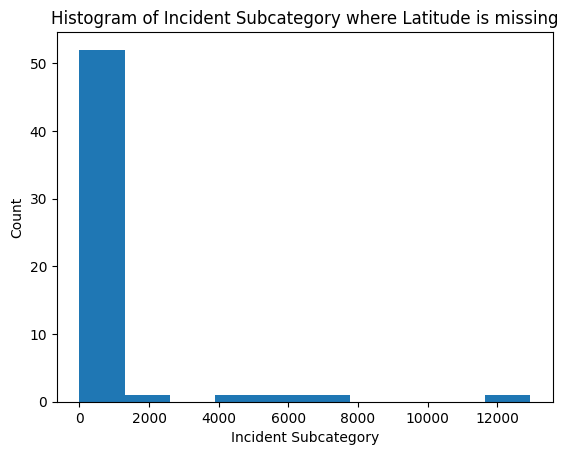

In [ ]:
no_lat = police['Incident Subcategory'][police['Latitude'].isnull()]
print("It occurs with {} categories out of {}".format(pd.unique(no_lat).size,pd.unique(police['Incident Subcategory']).size))

no_lat_counts = no_lat.value_counts()
plt.hist(no_lat_counts)

plt.xlabel('Incident Subcategory')
plt.ylabel('Count')
plt.title('Histogram of Incident Subcategory where Latitude is missing')

plt.show()

Given a small number of missing latitudes and longitudes and that almost every category has them we don't investigate further. We do not aim at traditional statistical tests in this project, and for training an neural net the amount of data we have for Larceny - From Vehicle should be enough to ensure diversity of the target even if some values are missing and some records will therefore be discarded.

In [ ]:
print("Creating a dataset with geographical coordinates of the most represented incident subcategory.")
larceny_fr_veh = police[:][police['Incident Subcategory'] == 'Larceny - From Vehicle']
larceny_fr_veh = larceny_fr_veh[:][larceny_fr_veh['Latitude'].isnull() == False]
larceny_fr_veh = larceny_fr_veh[:][larceny_fr_veh['Longitude'].isnull() == False]
larceny_fr_veh = larceny_fr_veh[['Latitude','Longitude']].copy()
print("Larceny - From Vehicle:")
display(larceny_fr_veh)


Creating a dataset with geographical coordinates of the most represented incident subcategory.
Larceny - From Vehicle:


,Latitude,Longitude
45,37.805497,-122.422007
58,37.784007,-122.404865
60,37.807073,-122.417261
62,37.807163,-122.408897
71,37.778021,-122.421521
...,...,...
693139,37.789783,-122.404208
693150,37.786085,-122.433272
693163,37.749187,-122.506219
693169,37.722726,-122.441431


## Connecting GSVI and crime geographical coordinates

We need the data in array form, so we create arrays.

In [ ]:
l_f_v_a = larceny_fr_veh.to_numpy()
gsv_a = gsv.to_numpy()

We only need SVI from San Francisco as that's the only source of crime data we have. Here we sample all the SVI coordinates that lay within San Francisco area. 

In [ ]:
#make a subset of the images locations for images from San Francisco
san_fran_ind = []
for i in range(len(gsv_a)):
    if geodesic(gsv_a[i],[37.755101, -122.446700]).km <= 30: #some spot in the middle for SF, 30 km is much more than needed
        san_fran_ind.append(i)
print(len(san_fran_ind))

san_fran = gsv_a[san_fran_ind]
print(san_fran.shape)

9625
(9625, 2)


In [ ]:
print(l_f_v_a.shape) #let's see what the size of the selected crimes locations is

(107065, 2)


To visually explore the relationship beetween the data out of curiosity, we make a map here. The locations for which SVI are available in the dataset are marked in blue, and the locations for which larceny from vehicle was reported are marked in red.

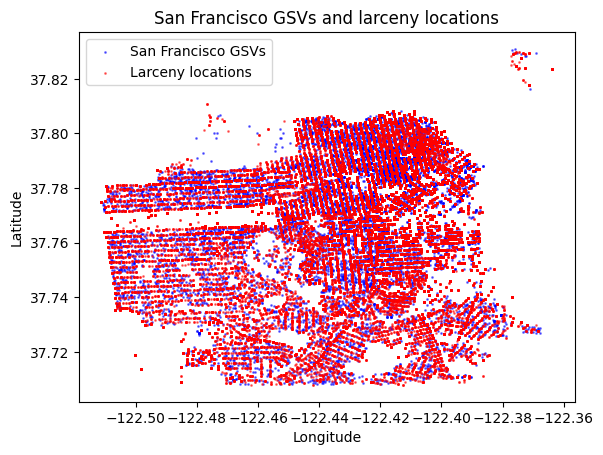

In [ ]:
# Scatter plot for San Francisco GSVs (blue dots)
plt.scatter(san_fran[:, 1], san_fran[:, 0], color='blue', s=1, alpha = 0.5, label='San Francisco GSVs')

# Scatter plot for Larceny locations (red dots)
plt.scatter(l_f_v_a[:, 1], l_f_v_a[:, 0], color='red', s=1, alpha = 0.5, label='Larceny locations')

# Set axis labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Set plot title
plt.title('San Francisco GSVs and larceny locations')

# Add legend
plt.legend()

# Display the plot
plt.show()

Well, just with a naked eye it looks like crime data is even more regular than the SVI. But there are some districts where red is more dense. Let's hope it shows up in the network training results.

Let's check if some of the coordinates are in both datasets, so if there are crimes that happened exactly at the location for which we have SVI available. 

In [ ]:
c = 0
for row in l_f_v_a:
    if row in gsv_a:
        c+=1
print(c)

0


So, none of the exact locations of crime are on the photo. Then we have to define some measure of viscinity to look into the pictures in the close viscinity from the crime scene. 

We now find the locations in two datasets that are close to each other. After trying different radius, from 20 to 50 meters, we chose 35 meters, because then it still makes more or less sense (the street probably looked the same 35 meters around the crime scene, at least some features should be there), but also it still produces enough labels in the minority class to train the model.

In [ ]:
labels = np.zeros(san_fran.shape[0])
for i in range(san_fran.shape[0]):
    for j in range(l_f_v_a.shape[0]):
        if geodesic(san_fran[i],l_f_v_a[j]).km <= 0.035:
            labels[i] = 1

np.savez_compressed('labels.npz', labels=labels)


# Fine-tune pre-trained ViT

We use DeiT Tiny here because the visualization pipeline that we adapt from Gildenblat, J. (2020). Exploring Explainability for Vision Transformers. https://jacobgil.github.io/deeplearning/vision-transformer-explainability is developed based on DeiT Tiny.

### Loading images
Because my images are not ImageNet, they are stored all in one folder, I need to create a custom dataset object in order to load them according to the labels stored in a separate array.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, label

We also create a folder with only the San Francisco images. I ran the code below on my local PC and then upload the resulting folder to the Google Drive to have access to it from here. One could try to use it this way, or to run it on Colab, but I don't know if that would work. Anyways, create the "Only_San_Fran" directory first. 

In [ ]:
import shutil

files_to_move = [f'street_view_{index}.jpg' for index in san_fran_ind]
print(files_to_move)

src_dir = './'
dst_dir = src_dir+'Only_San_Fran/'

for file in files_to_move:
    shutil.copy(src_dir+file, dst_dir+file)

In [ ]:
#produce the image paths, import the labels
image_paths = os.listdir('./Only_San_Fran')
labels_init = np.load('labels_35_m.npz')['labels']
image_paths.sort(key=lambda x: int(x[12:-4]))
print(image_paths[:20])
print(labels_init[:20])
labels_init = labels_init.astype(int)
print(labels_init[:20])

os.chdir("./Only_San_Fran")

['street_view_3.jpg', 'street_view_7.jpg', 'street_view_11.jpg', 'street_view_13.jpg', 'street_view_16.jpg', 'street_view_27.jpg', 'street_view_31.jpg', 'street_view_37.jpg', 'street_view_38.jpg', 'street_view_41.jpg', 'street_view_43.jpg', 'street_view_62.jpg', 'street_view_63.jpg', 'street_view_64.jpg', 'street_view_66.jpg', 'street_view_76.jpg', 'street_view_78.jpg', 'street_view_80.jpg', 'street_view_82.jpg', 'street_view_84.jpg']
[False False  True False False False  True  True  True  True False False
  True False False False False  True  True False]
[0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0]


In [ ]:
# Calculate the class imbalance ratio
positive_count = np.sum(labels_init)
negative_count = len(labels_init) - positive_count
imbalance_ratio = negative_count / positive_count
print(positive_count, negative_count, imbalance_ratio)

2384 7241 3.0373322147651005


In [ ]:
#define transforms, create your dataset using the defined paths and create the data loader

# Define the data transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

custom_dataset = CustomDataset(image_paths, labels_init, transform=train_transforms)


Split the data:

In [ ]:
# Determine the size of the train/validation split
train_size = int(len(custom_dataset) * 0.25) #let's keep the amount of data small for model selection
val_size = int(len(custom_dataset) * 0.15)
test_size = len(custom_dataset) - train_size - val_size

# Randomly split the dataset into train and validation sets
train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

You always need to install timm while on Colab when you run this notebook.

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.0 MB/s eta 0:00:00


Now we will perform model selection. In order to be able to test a number of hyperparameters without re-defining model in the code every time, we define a function for building and training a model and displaying some metrics on it. 

In [ ]:
def train_custom_model(model_name, unfreeze_layers, optimizer_fn, lr):

  #load the pre-trained model:
  model = torch.hub.load('facebookresearch/deit:main', model_name, pretrained=True)

  # Get the number of transformer layers
  num_transformer_layers = len(model.blocks)

  # Freeze all layers except the specified number of unfrozen layers
  for i in range(num_transformer_layers - unfreeze_layers):
      for param in model.blocks[i].parameters():
          param.requires_grad = False

  #adjust the head
  num_classes = 1
  in_features = model.head.in_features

  model.head = nn.Sequential(
      nn.BatchNorm1d(num_features=in_features), #include batch normalization for efficiency
      nn.ReLU(),
      nn.Linear(in_features, num_classes)
  )

  model = model.to(device)

  #create a weight tensor for the positive (minor) class
  pos_weight = torch.FloatTensor([imbalance_ratio]).to(device)

  #define the loss function
  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device) #this one includes Sigmoid 
  #it's advised by Torch to use this instead of nn.Sigmoid in the net and BCELoss here. More stable.

  #define your optimizer
  optimizer = optimizer_fn(model.parameters(), lr=lr)

  #define the learning rate scheduler
  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

  num_epochs = 15
  for epoch in range(num_epochs):
      # Training
      train_loss = 0.0
      train_correct = 0
      train_total = 0
      train_f1_total = 0
      model.train()
      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs.squeeze(), labels.float())
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
          outputs = torch.sigmoid(outputs)  # apply sigmoid to get probabilities
          preds = (outputs.squeeze() >= 0.5).float()  
          train_correct += torch.sum(preds == labels.data)
          train_total += labels.size(0)
          train_f1_total += f1_score(labels.cpu().detach(), preds.cpu().detach(), average='weighted') * labels.size(0)

      train_loss = train_loss / len(train_loader.dataset)
      train_acc = train_correct.item() / train_total
      train_f1 = train_f1_total / train_total

      # Validation
      val_loss = 0.0
      val_correct = 0
      val_total = 0
      val_f1_total = 0
      model.eval()
      with torch.no_grad():
          for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              loss = criterion(outputs.squeeze(), labels.float())
              val_loss += loss.item()
              outputs = torch.sigmoid(outputs)
              preds = (outputs.squeeze() >= 0.5).float()
              val_correct += torch.sum(preds == labels.data)  
              val_total += labels.size(0)
              val_f1_total += f1_score(labels.cpu().detach(), preds.cpu().detach(), average='weighted') * labels.size(0)

      val_loss = val_loss / len(val_loader.dataset)
      val_acc = val_correct.item() / val_total
      val_f1 = val_f1_total / val_total

      scheduler.step(val_loss)

      print(f'Epoch [{epoch+1}/{num_epochs}],\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, \
      Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

Now we can do hyperparameter exploration with our small training sample and our custom function. We will later train the most promising model with more data and for more epochs.

In [ ]:
m_names = ['deit_tiny_patch16_224', 'deit_small_patch16_224']
to_unfreeze = [0,1,2,5]
lr_s = [0.001, 0.01]
optimizers = [optim.Adam, optim.SGD, optim.Adagrad]

for m_n in m_names:
  for to_unfr in to_unfreeze:
    for lr in lr_s:
      for opt in optimizers:
        print(m_n, to_unfr, lr, str(opt), end='\n\n')
        train_custom_model(m_n, to_unfr, opt, lr)
        print('')

deit_tiny_patch16_224 0 0.001 <class 'torch.optim.adam.Adam'>



Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_patch16_224-a1311bcf.pth
100%|██████████| 21.9M/21.9M [00:00<00:00, 109MB/s]


Epoch [1/15],
Train Loss: 0.0332, Train Acc: 0.5179,       Train F1: 0.5427, Val Loss: 0.0335, Val Acc: 0.5191, Val F1: 0.5524
Epoch [2/15],
Train Loss: 0.0332, Train Acc: 0.5432,       Train F1: 0.5678, Val Loss: 0.0336, Val Acc: 0.4816, Val F1: 0.5125
Epoch [3/15],
Train Loss: 0.0331, Train Acc: 0.5374,       Train F1: 0.5668, Val Loss: 0.0334, Val Acc: 0.6168, Val F1: 0.6323
Epoch [4/15],
Train Loss: 0.0330, Train Acc: 0.5183,       Train F1: 0.5494, Val Loss: 0.0334, Val Acc: 0.7034, Val F1: 0.6754
Epoch [5/15],
Train Loss: 0.0330, Train Acc: 0.5528,       Train F1: 0.5819, Val Loss: 0.0334, Val Acc: 0.4893, Val F1: 0.5220
Epoch [6/15],
Train Loss: 0.0331, Train Acc: 0.5470,       Train F1: 0.5782, Val Loss: 0.0329, Val Acc: 0.5336, Val F1: 0.5675
Epoch [7/15],
Train Loss: 0.0330, Train Acc: 0.5544,       Train F1: 0.5828, Val Loss: 0.0328, Val Acc: 0.5807, Val F1: 0.6085
Epoch [8/15],
Train Loss: 0.0326, Train Acc: 0.5411,       Train F1: 0.5713, Val Loss: 0.0330, Val Acc: 0.4692,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0336, Train Acc: 0.4983,       Train F1: 0.5337, Val Loss: 0.0338, Val Acc: 0.4955, Val F1: 0.5320
Epoch [2/15],
Train Loss: 0.0336, Train Acc: 0.5042,       Train F1: 0.5394, Val Loss: 0.0339, Val Acc: 0.5107, Val F1: 0.5455
Epoch [3/15],
Train Loss: 0.0335, Train Acc: 0.5025,       Train F1: 0.5374, Val Loss: 0.0337, Val Acc: 0.5080, Val F1: 0.5407
Epoch [4/15],
Train Loss: 0.0332, Train Acc: 0.5108,       Train F1: 0.5462, Val Loss: 0.0334, Val Acc: 0.5412, Val F1: 0.5731
Epoch [5/15],
Train Loss: 0.0331, Train Acc: 0.5054,       Train F1: 0.5402, Val Loss: 0.0335, Val Acc: 0.5149, Val F1: 0.5492
Epoch [6/15],
Train Loss: 0.0327, Train Acc: 0.5353,       Train F1: 0.5708, Val Loss: 0.0331, Val Acc: 0.5329, Val F1: 0.5662
Epoch [7/15],
Train Loss: 0.0329, Train Acc: 0.5291,       Train F1: 0.5646, Val Loss: 0.0329, Val Acc: 0.5537, Val F1: 0.5852
Epoch [8/15],
Train Loss: 0.0332, Train Acc: 0.5353,       Train F1: 0.5705, Val Loss: 0.0331, Val Acc: 0.5315,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0336, Train Acc: 0.5357,       Train F1: 0.5674, Val Loss: 0.0337, Val Acc: 0.5350, Val F1: 0.5669
Epoch [2/15],
Train Loss: 0.0332, Train Acc: 0.5258,       Train F1: 0.5606, Val Loss: 0.0334, Val Acc: 0.5080, Val F1: 0.5407
Epoch [3/15],
Train Loss: 0.0329, Train Acc: 0.5278,       Train F1: 0.5627, Val Loss: 0.0329, Val Acc: 0.5482, Val F1: 0.5795
Epoch [4/15],
Train Loss: 0.0326, Train Acc: 0.5357,       Train F1: 0.5691, Val Loss: 0.0334, Val Acc: 0.5163, Val F1: 0.5499
Epoch [5/15],
Train Loss: 0.0328, Train Acc: 0.5495,       Train F1: 0.5810, Val Loss: 0.0331, Val Acc: 0.5301, Val F1: 0.5628
Epoch [6/15],
Train Loss: 0.0327, Train Acc: 0.5507,       Train F1: 0.5846, Val Loss: 0.0329, Val Acc: 0.5405, Val F1: 0.5736
Epoch [7/15],
Train Loss: 0.0324, Train Acc: 0.5499,       Train F1: 0.5824, Val Loss: 0.0325, Val Acc: 0.5405, Val F1: 0.5727
Epoch [8/15],
Train Loss: 0.0323, Train Acc: 0.5628,       Train F1: 0.5959, Val Loss: 0.0326, Val Acc: 0.5509,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0345, Train Acc: 0.5137,       Train F1: 0.5198, Val Loss: 0.0339, Val Acc: 0.5565, Val F1: 0.5846
Epoch [2/15],
Train Loss: 0.0342, Train Acc: 0.4950,       Train F1: 0.5088, Val Loss: 0.0346, Val Acc: 0.6008, Val F1: 0.6114
Epoch [3/15],
Train Loss: 0.0334, Train Acc: 0.5170,       Train F1: 0.5335, Val Loss: 0.0336, Val Acc: 0.6535, Val F1: 0.6630
Epoch [4/15],
Train Loss: 0.0334, Train Acc: 0.5353,       Train F1: 0.5468, Val Loss: 0.0345, Val Acc: 0.5149, Val F1: 0.5477
Epoch [5/15],
Train Loss: 0.0334, Train Acc: 0.5187,       Train F1: 0.5278, Val Loss: 0.0329, Val Acc: 0.5655, Val F1: 0.5963
Epoch [6/15],
Train Loss: 0.0332, Train Acc: 0.5378,       Train F1: 0.5573, Val Loss: 0.0331, Val Acc: 0.4040, Val F1: 0.4053
Epoch [7/15],
Train Loss: 0.0330, Train Acc: 0.5549,       Train F1: 0.5779, Val Loss: 0.0332, Val Acc: 0.5703, Val F1: 0.5971
Epoch [8/15],
Train Loss: 0.0332, Train Acc: 0.5615,       Train F1: 0.5859, Val Loss: 0.0334, Val Acc: 0.4816,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0331, Train Acc: 0.4875,       Train F1: 0.5096, Val Loss: 0.0333, Val Acc: 0.6660, Val F1: 0.6706
Epoch [2/15],
Train Loss: 0.0326, Train Acc: 0.5536,       Train F1: 0.5801, Val Loss: 0.0328, Val Acc: 0.6542, Val F1: 0.6600
Epoch [3/15],
Train Loss: 0.0328, Train Acc: 0.5532,       Train F1: 0.5801, Val Loss: 0.0326, Val Acc: 0.5364, Val F1: 0.5686
Epoch [4/15],
Train Loss: 0.0328, Train Acc: 0.5233,       Train F1: 0.5522, Val Loss: 0.0320, Val Acc: 0.6389, Val F1: 0.6598
Epoch [5/15],
Train Loss: 0.0322, Train Acc: 0.5673,       Train F1: 0.5940, Val Loss: 0.0321, Val Acc: 0.6590, Val F1: 0.6731
Epoch [6/15],
Train Loss: 0.0321, Train Acc: 0.5840,       Train F1: 0.6106, Val Loss: 0.0323, Val Acc: 0.6854, Val F1: 0.6870
Epoch [7/15],
Train Loss: 0.0320, Train Acc: 0.6002,       Train F1: 0.6226, Val Loss: 0.0322, Val Acc: 0.5759, Val F1: 0.6058
Epoch [8/15],
Train Loss: 0.0321, Train Acc: 0.5910,       Train F1: 0.6170, Val Loss: 0.0323, Val Acc: 0.6521,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0336, Train Acc: 0.5262,       Train F1: 0.5437, Val Loss: 0.0333, Val Acc: 0.6625, Val F1: 0.6636
Epoch [2/15],
Train Loss: 0.0334, Train Acc: 0.6031,       Train F1: 0.6125, Val Loss: 0.0334, Val Acc: 0.2696, Val F1: 0.1645
Epoch [3/15],
Train Loss: 0.0334, Train Acc: 0.4705,       Train F1: 0.4921, Val Loss: 0.0331, Val Acc: 0.3721, Val F1: 0.3627
Epoch [4/15],
Train Loss: 0.0331, Train Acc: 0.5441,       Train F1: 0.5705, Val Loss: 0.0332, Val Acc: 0.4123, Val F1: 0.4208
Epoch [5/15],
Train Loss: 0.0330, Train Acc: 0.5112,       Train F1: 0.5438, Val Loss: 0.0331, Val Acc: 0.6902, Val F1: 0.6834
Epoch [6/15],
Train Loss: 0.0329, Train Acc: 0.5835,       Train F1: 0.6068, Val Loss: 0.0333, Val Acc: 0.5994, Val F1: 0.6237
Epoch [7/15],
Train Loss: 0.0328, Train Acc: 0.5594,       Train F1: 0.5872, Val Loss: 0.0329, Val Acc: 0.6507, Val F1: 0.6577
Epoch [8/15],
Train Loss: 0.0328, Train Acc: 0.5765,       Train F1: 0.6044, Val Loss: 0.0330, Val Acc: 0.6188,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0339, Train Acc: 0.4884,       Train F1: 0.5161, Val Loss: 0.0344, Val Acc: 0.2710, Val F1: 0.1643
Epoch [2/15],
Train Loss: 0.0337, Train Acc: 0.5291,       Train F1: 0.5439, Val Loss: 0.0332, Val Acc: 0.6743, Val F1: 0.6640
Epoch [3/15],
Train Loss: 0.0335, Train Acc: 0.4830,       Train F1: 0.5045, Val Loss: 0.0335, Val Acc: 0.3957, Val F1: 0.4052
Epoch [4/15],
Train Loss: 0.0334, Train Acc: 0.4593,       Train F1: 0.4694, Val Loss: 0.0337, Val Acc: 0.4158, Val F1: 0.4344
Epoch [5/15],
Train Loss: 0.0332, Train Acc: 0.5594,       Train F1: 0.5853, Val Loss: 0.0339, Val Acc: 0.3028, Val F1: 0.2402
Epoch [6/15],
Train Loss: 0.0333, Train Acc: 0.5191,       Train F1: 0.5381, Val Loss: 0.0341, Val Acc: 0.7263, Val F1: 0.6725
Epoch [7/15],
Train Loss: 0.0330, Train Acc: 0.5116,       Train F1: 0.5410, Val Loss: 0.0329, Val Acc: 0.5870, Val F1: 0.6145
Epoch [8/15],
Train Loss: 0.0332, Train Acc: 0.5046,       Train F1: 0.5299, Val Loss: 0.0333, Val Acc: 0.7325,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0342, Train Acc: 0.5711,       Train F1: 0.5945, Val Loss: 0.0340, Val Acc: 0.5163, Val F1: 0.5491
Epoch [2/15],
Train Loss: 0.0335, Train Acc: 0.5249,       Train F1: 0.5584, Val Loss: 0.0333, Val Acc: 0.5343, Val F1: 0.5686
Epoch [3/15],
Train Loss: 0.0337, Train Acc: 0.5062,       Train F1: 0.5422, Val Loss: 0.0335, Val Acc: 0.4976, Val F1: 0.5319
Epoch [4/15],
Train Loss: 0.0333, Train Acc: 0.5150,       Train F1: 0.5507, Val Loss: 0.0333, Val Acc: 0.5204, Val F1: 0.5548
Epoch [5/15],
Train Loss: 0.0333, Train Acc: 0.5104,       Train F1: 0.5461, Val Loss: 0.0334, Val Acc: 0.5239, Val F1: 0.5583
Epoch [6/15],
Train Loss: 0.0335, Train Acc: 0.5079,       Train F1: 0.5427, Val Loss: 0.0328, Val Acc: 0.5419, Val F1: 0.5750
Epoch [7/15],
Train Loss: 0.0329, Train Acc: 0.5220,       Train F1: 0.5576, Val Loss: 0.0328, Val Acc: 0.5551, Val F1: 0.5872
Epoch [8/15],
Train Loss: 0.0329, Train Acc: 0.5611,       Train F1: 0.5928, Val Loss: 0.0331, Val Acc: 0.5267,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0332, Train Acc: 0.5806,       Train F1: 0.6003, Val Loss: 0.0330, Val Acc: 0.6244, Val F1: 0.6422
Epoch [2/15],
Train Loss: 0.0328, Train Acc: 0.5798,       Train F1: 0.6091, Val Loss: 0.0331, Val Acc: 0.5544, Val F1: 0.5852
Epoch [3/15],
Train Loss: 0.0326, Train Acc: 0.5744,       Train F1: 0.6061, Val Loss: 0.0329, Val Acc: 0.5135, Val F1: 0.5464
Epoch [4/15],
Train Loss: 0.0323, Train Acc: 0.5607,       Train F1: 0.5934, Val Loss: 0.0330, Val Acc: 0.5343, Val F1: 0.5669
Epoch [5/15],
Train Loss: 0.0320, Train Acc: 0.5873,       Train F1: 0.6180, Val Loss: 0.0332, Val Acc: 0.5308, Val F1: 0.5632
Epoch [6/15],
Train Loss: 0.0321, Train Acc: 0.5902,       Train F1: 0.6191, Val Loss: 0.0328, Val Acc: 0.5793, Val F1: 0.6090
Epoch [7/15],
Train Loss: 0.0316, Train Acc: 0.5943,       Train F1: 0.6235, Val Loss: 0.0330, Val Acc: 0.5821, Val F1: 0.6094
Epoch [8/15],
Train Loss: 0.0314, Train Acc: 0.5993,       Train F1: 0.6283, Val Loss: 0.0325, Val Acc: 0.6050,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0350, Train Acc: 0.5237,       Train F1: 0.4912, Val Loss: 0.0361, Val Acc: 0.2467, Val F1: 0.1042
Epoch [2/15],
Train Loss: 0.0344, Train Acc: 0.4904,       Train F1: 0.4838, Val Loss: 0.0350, Val Acc: 0.2883, Val F1: 0.1991
Epoch [3/15],
Train Loss: 0.0337, Train Acc: 0.4688,       Train F1: 0.4597, Val Loss: 0.0344, Val Acc: 0.2633, Val F1: 0.1400
Epoch [4/15],
Train Loss: 0.0334, Train Acc: 0.5104,       Train F1: 0.4881, Val Loss: 0.0334, Val Acc: 0.3756, Val F1: 0.3693
Epoch [5/15],
Train Loss: 0.0335, Train Acc: 0.4098,       Train F1: 0.4126, Val Loss: 0.0334, Val Acc: 0.3181, Val F1: 0.2617
Epoch [6/15],
Train Loss: 0.0332, Train Acc: 0.4015,       Train F1: 0.3687, Val Loss: 0.0350, Val Acc: 0.7526, Val F1: 0.6493
Epoch [7/15],
Train Loss: 0.0330, Train Acc: 0.5399,       Train F1: 0.5395, Val Loss: 0.0333, Val Acc: 0.3070, Val F1: 0.2506
Epoch [8/15],
Train Loss: 0.0330, Train Acc: 0.3953,       Train F1: 0.3888, Val Loss: 0.0354, Val Acc: 0.3832,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0334, Train Acc: 0.5407,       Train F1: 0.5617, Val Loss: 0.0332, Val Acc: 0.4997, Val F1: 0.5315
Epoch [2/15],
Train Loss: 0.0333, Train Acc: 0.5224,       Train F1: 0.5553, Val Loss: 0.0328, Val Acc: 0.5759, Val F1: 0.6061
Epoch [3/15],
Train Loss: 0.0331, Train Acc: 0.5108,       Train F1: 0.5413, Val Loss: 0.0331, Val Acc: 0.4463, Val F1: 0.4684
Epoch [4/15],
Train Loss: 0.0328, Train Acc: 0.5673,       Train F1: 0.5937, Val Loss: 0.0335, Val Acc: 0.3430, Val F1: 0.3121
Epoch [5/15],
Train Loss: 0.0322, Train Acc: 0.5278,       Train F1: 0.5424, Val Loss: 0.0331, Val Acc: 0.7124, Val F1: 0.6932
Epoch [6/15],
Train Loss: 0.0323, Train Acc: 0.5865,       Train F1: 0.6074, Val Loss: 0.0331, Val Acc: 0.5849, Val F1: 0.6135
Epoch [7/15],
Train Loss: 0.0326, Train Acc: 0.5561,       Train F1: 0.5868, Val Loss: 0.0327, Val Acc: 0.6653, Val F1: 0.6663
Epoch [8/15],
Train Loss: 0.0319, Train Acc: 0.5998,       Train F1: 0.6254, Val Loss: 0.0324, Val Acc: 0.6244,

In [ ]:
#if you ever want to see how well Colab is utilizing GPU for your code, build this statement into the loop:
!nvidia-smi

Tue Apr 11 14:53:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    31W /  70W |   1213MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Epoch [1/15],
Train Loss: 0.0325, Train Acc: 0.5495,     Train F1: 0.5811, Val Loss: 0.0325, Val Acc: 0.5579, Val F1: 0.5914
Epoch [2/15],
Train Loss: 0.0320, Train Acc: 0.5753,     Train F1: 0.6039, Val Loss: 0.0318, Val Acc: 0.6161, Val F1: 0.6427
Epoch [3/15],
Train Loss: 0.0318, Train Acc: 0.5786,     Train F1: 0.6050, Val Loss: 0.0317, Val Acc: 0.6396, Val F1: 0.6550
Epoch [4/15],
Train Loss: 0.0315, Train Acc: 0.5969,     Train F1: 0.6228, Val Loss: 0.0320, Val Acc: 0.6570, Val F1: 0.6696
Epoch [5/15],
Train Loss: 0.0315, Train Acc: 0.6012,     Train F1: 0.6267, Val Loss: 0.0317, Val Acc: 0.6008, Val F1: 0.6318
Epoch [6/15],
Train Loss: 0.0315, Train Acc: 0.6001,     Train F1: 0.6273, Val Loss: 0.0320, Val Acc: 0.5780, Val F1: 0.6105
Epoch [7/15],
Train Loss: 0.0315, Train Acc: 0.5997,     Train F1: 0.6275, Val Loss: 0.0317, Val Acc: 0.5648, Val F1: 0.5992
Epoch [8/15],
Train Loss: 0.0313, Train Acc: 0.6148,     Train F1: 0.6391, Val Loss: 0.0317, Val Acc: 0.5218, Val F1: 0.5562


So, the performance is far from impressive. Let's experiment with the architecture and augment the data maybe. 

# Unsorted stuff from before

In [ ]:
s, ss = 2000, 2050
indxs = list(range(s,ss))
images = [Image.open(path) for path in image_paths[s:ss]]
inputs = [val_transforms(image).unsqueeze(0) for image in images]
inputs = torch.stack(inputs)
inputs = inputs.to(device)
outs = {}

model.eval()
with torch.no_grad():
  for input, i in zip(inputs,indxs):
    output = model(input)
    outs[output.item()] = image_paths[i]
    preds = torch.round(torch.sigmoid(output))
    print(f"{i}, {image_paths[i]} preds: {preds.item()}, orig: {labels_init[i]}")

keys_sorted = list(outs.keys()) 
keys_sorted.sort()
for j in keys_sorted[:5]:
  print(outs[j], j)

To scan through more images use this:

In [ ]:
s, ss = 300, 800
indxs = list(range(s,ss))
images = torch.empty((len(indxs),3,224,224), dtype = torch.float32, device=device)
for i,ind in enumerate(indxs):
  img = Image.open(image_paths[ind])
  inp = val_transforms(img).unsqueeze(0).to(device)
  images[i] = inp

In [ ]:
outs = {}

model.eval()
with torch.no_grad():
  for input, i in zip(images,indxs):
    output = model(input)
    outs[output.item()] = image_paths[i]

keys_sorted = list(outs.keys()) 
keys_sorted.sort(reverse=True)
for j in keys_sorted[:5]:
  print(outs[j], j)

So this one does actually learn something.

# To save the model:

In [ ]:
#save the model - what if it's good enough
model_name = '/model_demo.pth' #change this if you wish
model_name = PATH + model_name
torch.save(model, model_name)


#to load the model later:

In [ ]:
#define the architecture and use all the pretraining:
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

#modify the architecture for your needs and also the way it was during fine-tuning:
num_classes = 2
in_features = model.head.in_features
model.head = nn.Linear(in_features, num_classes)

#load the state dictionary of the model fine-tuned on your data:
model.load_state_dict(torch.load('content/drive/MyDrive/for thesis/model_first_try.pth'))

In [ ]:
#or if it's not the state dict, but just the model itself:
!pip install timm
model = torch.load('model_fourth_try.pth')
model = model.to(device)

In [ ]:
model

# Following the Gildenblat's post on heat maps for vision transformers

In [ ]:
os.chdir(os.pardir)
print(os.getcwd())

In [ ]:
!git clone https://github.com/jacobgil/vit-explain

In [ ]:
os.chdir('./vit-explain')
!ls

In [ ]:
!pip uninstall opencv-python-headless -y
!pip install opencv-python-headless


In [ ]:
!python vit_explain.py --image_path street_view_11.jpg --head_fusion max --discard_ratio 0.9 --category_index 1

In [ ]:
print(os.getcwd())

For this to work I modified the original function a bit, inserted device as an argument to ensure the code can run on Google Colab on GPU, otherwise it kept giving RuntimeError because tensors are on different GPUs.

In [ ]:
from vit_grad_rollout import VITAttentionGradRollout, grad_rollout

# Load an example image
image = Image.open("street_view_11.jpg")

# Preprocess the image
input_tensor = val_transforms(image)
input_tensor = input_tensor.to(device)

# Create the grad rollout object
grad_rollout = VITAttentionGradRollout(model) #could also try , attention_layer_name='blocks.4.attn_drop'

# Get the mask for the input image
mask = grad_rollout(input_tensor.unsqueeze(0), category_index=1)

# Use the mask to highlight the important regions of the image
highlighted_image = input_tensor.permute(1, 2, 0) * mask[..., None]

# Save the highlighted image
transforms.ToPILImage()(highlighted_image).save("highlighted_image.jpg")


In [ ]:
from vit_grad_rollout import VITAttentionGradRollout

grad_rollout = VITAttentionGradRollout(model, discard_ratio=0.9, head_fusion='max')
mask = grad_rollout(input_tensor, category_index=243)

Okay, this doesn't want to work with Colab, so I try to pack the Command Line version in a command and extract images from it.

In [ ]:
import subprocess

# Set the arguments for the command
image_path = "street_view_11.jpg"
head_fusion = 'max'
discard_ratio = 0.85
category_index = 1

# Construct the command as a list of strings
command = ['python', 'vit_explain.py',
           '--image_path', image_path,
           '--head_fusion', head_fusion,
           '--discard_ratio', str(discard_ratio),
           '--category_index', str(category_index)]

# Run the command and capture the output
output = subprocess.check_output(command)

# Print the output
print(output)


Okay, this part doesn't seem to work on Colab as of now, so I move to Jupyter. But I can load the model here again and experiment with it further. I might also fine-tune the model here further. 

# Gildenblat's post: his py file just in here to control what it does

In [ ]:
#to use the functions I have to import the pack:
#!git clone https://github.com/jacobgil/vit-explain
os.chdir('./vit-explain')

Below is the function of Gildenblat's, but without running the file through the command line. And it imports the other his functions from the files. 

In [ ]:
print(os.getcwd())

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
import numpy as np
import cv2
from vit_rollout import VITAttentionRollout
from vit_grad_rollout import VITAttentionGradRollout

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

def vit_explain(image_path, head_fusion, discard_ratio, category_index=None, use_cuda=False):

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    img = Image.open(image_path)
    img = img.resize((224, 224))
    input_tensor = transform(img).unsqueeze(0)
    if use_cuda:
        input_tensor = input_tensor.cuda()

    if category_index is None:
        print("Doing Attention Rollout")
        attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, discard_ratio=discard_ratio)
        mask = attention_rollout(input_tensor)
        name = "attention_rollout_{:.3f}_{}.png".format(discard_ratio, head_fusion)
    else:
        print("Doing Gradient Attention Rollout")
        grad_rollout = VITAttentionGradRollout(model, discard_ratio=discard_ratio)
        mask = grad_rollout(input_tensor, category_index)
        name = "grad_rollout_{}_{:.3f}_{}.png".format(category_index, discard_ratio, head_fusion)

    np_img = np.array(img)[:, :, ::-1]
    mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
    mask = show_mask_on_image(np_img, mask)
    cv2.imshow("Input Image", np_img)
    cv2.imshow(name, mask)
    cv2.imwrite("input.png", np_img)
    cv2.imwrite(name, mask)
    cv2.waitKey(-1)

vit_explain('../Only_San_Fran/street_view_11.jpg', 'max', 0.9, 1, True)


For this to work I, based on the suggestion of the chat, modified vit_grad_rollout.py's method __call__ so that it works with my single output node fine-tuned model instad of expecting one-hot-encoded predictions. 